In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import math
import random
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
def rmsle(y, y_pred):     
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
def rmsle_loss(y_pred, y_true):
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [80]:
def lstm_univariate_loop(dataset):
    
    random.seed(1)
    dataset = df.values
    dataset = df.astype('float32')
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # split into train and test sets
    print('Spliting into train and test')
    train_size = int(32160)
    test_size = 1440
    train, test = dataset[0:train_size,:], dataset[train_size:33600,:]
    
    # reshape into X=t and Y=t+1
    look_back = 3
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    testY_copy = testY.copy()
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    print('Creating and fitting the LSTM network')
    
    model = Sequential()
    model.add(LSTM(200, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss=rmsle_loss, optimizer='adam', metrics = [rmsle_loss])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    model.fit(trainX, trainY, epochs=15, batch_size=70,validation_split=0.04, verbose=1, shuffle=False, callbacks = [es])
    
    
    
    
    
    # make predictions
    print('Making predictions')
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    #Metrics
    print('Calculating metrics')
    rmsle_i = rmsle(testY_copy,testPredict)
    
    return rmsle_i

In [81]:
# load the dataset
path = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/code_datasets/1_data_frames/fiveperc/com_std"
all_files = glob.glob(path + "/*.csv")

i = 0
rmsle_t = []
for filename in all_files:
    i = i + 1
    print('filename number ' + str(i) + ' of ' + str(len(all_files)) + str(filename))
    df = pd.read_csv(filename)
    df.set_index("tstp", inplace = True)
    rmsle_i = lstm_univariate_loop(df)
    rmsle_t.append(round(rmsle_i,3))
    

filename number 1 of 4/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/code_datasets/1_data_frames/fiveperc/com_std/MAC000059.csv
Spliting into train and test
Creating and fitting the LSTM network
Train on 30869 samples, validate on 1287 samples
Epoch 1/15
30869/30869 [==============================] - 3s 108us/step - loss: 0.0514 - rmsle_loss: 0.0514 - val_loss: 0.0567 - val_rmsle_loss: 0.0569
Epoch 2/15
30869/30869 [==============================] - 3s 94us/step - loss: 0.0487 - rmsle_loss: 0.0487 - val_loss: 0.0561 - val_rmsle_loss: 0.0564
Epoch 3/15
30869/30869 [==============================] - 3s 90us/step - loss: 0.0484 - rmsle_loss: 0.0484 - val_loss: 0.0558 - val_rmsle_loss: 0.0560
Epoch 4/15
30869/30869 [==============================] - 3s 91us/step - loss: 0.0482 - rmsle_loss: 0.0482 - val_loss: 0.0555 - val_rmsle_loss: 0.0557
Epoch 5/15
30869/30869 [==============================] - 3s 93us/step - loss: 0.0481 - rmsle_loss: 0.0481 - val_loss: 0.0552 

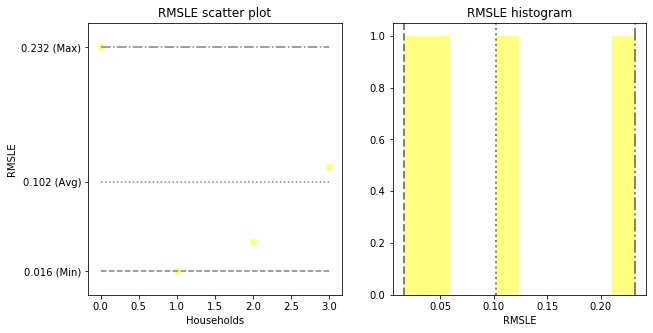

In [82]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(range(len(rmsle_t)),rmsle_t,color = 'yellow',alpha = 0.5)
plt.plot(range(len(rmsle_t)),[min(rmsle_t)]*len(rmsle_t),color = 'grey',linestyle = '--')
plt.plot(range(len(rmsle_t)),[round(np.average(rmsle_t),7)]*len(rmsle_t),color = 'grey',linestyle = ':')
plt.plot(range(len(rmsle_t)),[max(rmsle_t)]*len(rmsle_t),color = 'grey',linestyle = '-.')
plt.yticks([min(rmsle_t),round(np.average(rmsle_t),7),max(rmsle_t)],[str(min(rmsle_t)) + ' (Min)',
                                                            str(round(np.average(rmsle_t),7)) + ' (Avg)',
                                                                         str(max(rmsle_t))+' (Max)'])
plt.title('RMSLE scatter plot',fontsize = 12)
plt.xlabel('Households')
plt.ylabel('RMSLE')

plt.subplot(122)
plt.hist(rmsle_t,color = 'yellow',alpha = 0.5)
plt.axvline(x=min(rmsle_t), color='grey', linestyle='--', linewidth=2)
plt.axvline(x=round(np.average(rmsle_t),4), color='grey', linestyle=':', linewidth=2)
plt.axvline(x=max(rmsle_t), color='grey', linestyle='-.', linewidth=2)

plt.title("RMSLE histogram",fontsize = 12)
plt.xlabel('RMSLE')
plt.savefig('/Users/mariabelenalberti/Desktop/uni_results/RMSLE_200_com_std')

plt.show();

In [64]:
print(round(np.average(rmsle_t),7))

0.123


In [18]:
print(min(rmsle_t))

0.068
